## CHEME 5660 Value at Risk (VaR) Single Asset Example

## Introduction

## Example setup

In [1]:
import Pkg; Pkg.activate("."); Pkg.resolve(); Pkg.instantiate();

  Activating project at `~/Desktop/julia_work/CHEME-5660-Markets-Mayhem-Example-Notebooks/jupyter-notebooks/CHEME-5660-VaR-SingleAsset-Portfolio`
  No Changes to `~/Desktop/julia_work/CHEME-5660-Markets-Mayhem-Example-Notebooks/jupyter-notebooks/CHEME-5660-VaR-SingleAsset-Portfolio/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-5660-Markets-Mayhem-Example-Notebooks/jupyter-notebooks/CHEME-5660-VaR-SingleAsset-Portfolio/Manifest.toml`


In [11]:
# load req packages -
using FileIO
using JLD2
using DataFrames
using Dates
using Plots
using Colors
using Distributions
using StatsPlots

# setup paths -
const _ROOT = pwd();
const _PATH_TO_DATA = joinpath(_ROOT, "data");

┌ Info: Precompiling StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd]
└ @ Base loading.jl:1664


In [3]:
include("Example-VaR-CodeLib.jl");

In [28]:
# daily risk-free rate -
r̄ = 0.0403;
risk_free_daily = ((1+r̄)^(1/365) - 1);

# setup daily margin rate -
b̂ = 0.065;
margin_rate_daily = ((1+b̂)^(1/365) - 1);

# setup z_array -
z_array = [1.0, 1.96, 2.58, 3.29]; # confidence 68%, 95%, 99% and 99.9%

In [5]:
# load the JLD2 portfolio data file -
price_data_dictionary = clean(load(joinpath(_PATH_TO_DATA, "CHEME-5660-Portfolio-10-30-22.jld2"))["dd"]);

# we have these ticker symbols in our data set -
ticker_symbol_array = sort(keys(price_data_dictionary) |> collect);

# How many ticker symbols do we have?
Nₐ = length(ticker_symbol_array);

Length violation: META was removed; dim(SPY) = 597 days and dim(META) = 247 days
Length violation: BIIB was removed; dim(SPY) = 597 days and dim(BIIB) = 596 days


In [16]:
# what asset are calculating the VaR for?
ticker_symbol = "AMD"
start_index = 66;

# what is AMD IV?
IV = 58.88;

# How many days do we want to look at in the future?
T = 45; # units: days

# grab some data for AMD -
price_data_df = price_data_dictionary[ticker_symbol];
price_data = price_data_dictionary[ticker_symbol][end-start_index:end,:close];

# What is Sₒ?
Sₒ = price_data[end];

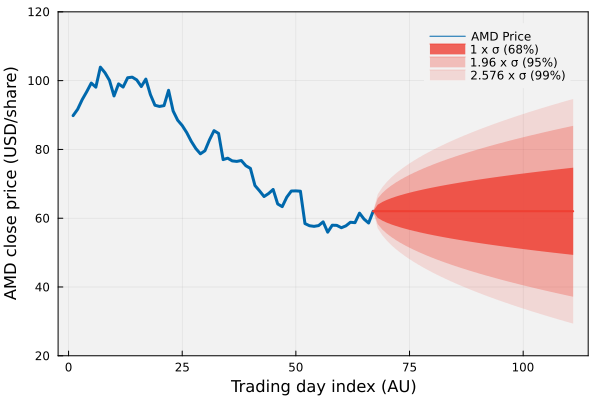

In [18]:
# make a cone plot -
future_array = Array{Float64,2}(undef, T, 8)
for i ∈ 1:T
    
    # compute σ -
    σ = Sₒ*(IV/100)*sqrt((i-1)/365);

    future_array[i,1] = i+start_index;
    future_array[i,2] = Sₒ
    future_array[i,3] = Sₒ + σ
    future_array[i,4] = Sₒ - σ
    future_array[i,5] = Sₒ + 1.96*σ
    future_array[i,6] = Sₒ - 1.96*σ
    future_array[i,7] = Sₒ + 2.576*σ
    future_array[i,8] = Sₒ - 2.576*σ
end


# plot the historical data -
plot(price_data_df[end-start_index:end,:close], lw=3, c=colorant"#0068AC", label="AMD Price", ylim=(20.0, 120))
plot!(future_array[:,1], future_array[:,2], c=colorant"#EF4035", 
    lw=2, bg=colorant"#F2F2F2", background_color_outside="white", framestyle = :box, fg_legend = :transparent, label="")

plot!(future_array[:,1], future_array[:,2], fillrange=future_array[:,3], c=colorant"#EF4035", alpha=0.8, label="")
plot!(future_array[:,1], future_array[:,2], fillrange=future_array[:,4], c=colorant"#EF4035", alpha=0.8, label="1 x σ (68%)")
plot!(future_array[:,1], future_array[:,2], fillrange=future_array[:,5], c=colorant"#EF4035", alpha=0.3, label="")
plot!(future_array[:,1], future_array[:,2], fillrange=future_array[:,6], c=colorant"#EF4035", alpha=0.3, label="1.96 x σ (95%)")
plot!(future_array[:,1], future_array[:,2], fillrange=future_array[:,7], c=colorant"#EF4035", alpha=0.15, label="")
plot!(future_array[:,1], future_array[:,2], fillrange=future_array[:,8], c=colorant"#EF4035", alpha=0.15, label="2.576 x σ (99%)")

xlabel!("Trading day index (AU)", fontsize=18)
ylabel!("AMD close price (USD/share)", fontsize=18)

In [7]:
# compute σ -
σ = Sₒ*(IV/100)*sqrt(T/365);

In [9]:
# compute the distribution for sampling -
d = Normal(Sₒ, σ);

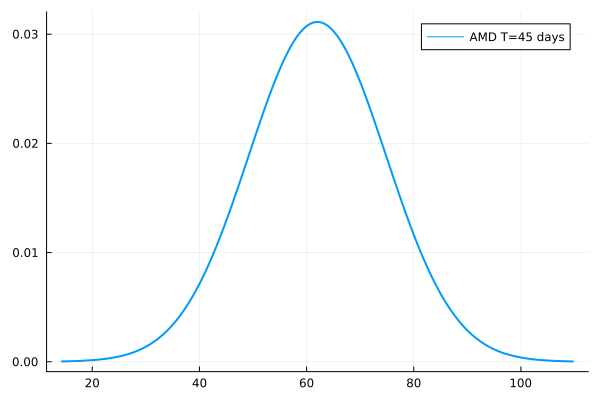

In [20]:
plot(d, label="AMD T=45 days", lw=2)

In [45]:
S_range = range(Sₒ - z_array[4]*σ, stop = Sₒ + z_array[4]*σ, step=0.01) |> collect;
cdf_array = Array{Float64, 2}(undef, length(S_range), 2);

for i ∈ 1:length(S_range)
    
    Sᵢ = S_range[i];
    cdf_value = cdf(d, Sᵢ);
    
    cdf_array[i,1] = Sᵢ;
    cdf_array[i,2] = cdf_value;
end

L = Int(round(0.3*length(S_range)));

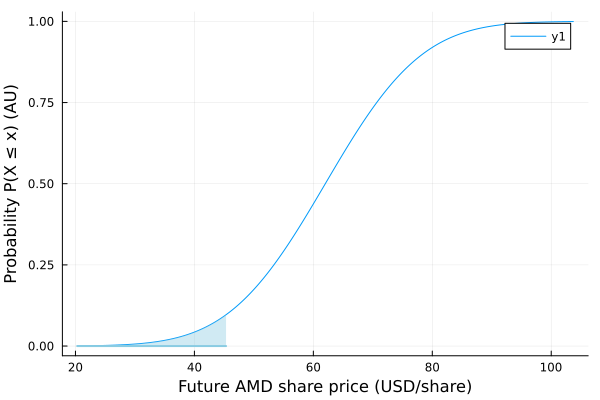

In [46]:
plot(cdf_array[:,1], cdf_array[:,2])
Z = zeros(L);
plot!(cdf_array[1:L,1], Z, fillrange=cdf_array[1:L,2], c=colorant"#89CCE2", fillalpha = 0.4, lw=2, label="")
xlabel!("Future $(ticker_symbol) share price (USD/share)", fontsize=18)
ylabel!("Probability P(X ≤ x) (AU)", fontsize=18)

### Disclaimer and Risks
__This content is offered solely for training and  informational purposes__. No offer or solicitation to buy or sell securities or derivative products, or any investment or trading advice or strategy,  is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance.  Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on your evaluation of your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.